In [1]:
!pip3 install torch torchvision torchaudio --quiet
!pip install gpytorch --quiet
!pip install mne --quiet
!pip install pandas --quiet
!pip install pywavelets --quiet
!pip install edfio --quiet
!pip install tqdm --quiet

### Imports

In [2]:
import os
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import mne
from mne.stats.parametric import _parametric_ci
from mne import create_info
from mne.io import RawArray

from KC_algorithm.model import score_KCs
from KC_algorithm.utils import EpochData
from KC_algorithm.plotting import KC_from_probas, plot_all_Kcs

from utils.plots import plot_Kcs_in_single_chart, plot_Kcs_in_single_chart_epoch_data, plot_kcs_per_minute_and_sleep_stages, KC_from_probas_epoch_data
from utils.io import import_event_and_stages_SHHS, get_total_recording_time, store_kcs_data, load_kcs_edf_files, load_invalid_kc_metadata, load_valid_kc_metadata
from utils.preprocessing import remove_steady_epochs, remove_standard_deviation_outliers
from utils.postprocessing import calculate_kcs_per_minute, filter_kcs_by_sleep_stages

Updated sk-learn import path


### Paths & Constants

In [3]:
DATASET_DIR = "/home/ec2-user/SageMaker/datasets/nsrr/shhs/"

# Get lists of all EDF and annotation files in their respective directories
edf_dir = os.path.join(DATASET_DIR, 'polysomnography/edfs/shhs1')
annot_dir = os.path.join(DATASET_DIR, 'polysomnography/annotations-events-nsrr/shhs1')
kcs_dir = os.path.join(DATASET_DIR, 'preprocessed/shhs1')
datasets_dir = os.path.join(DATASET_DIR, 'datasets')


edf_files = sorted([os.path.join(edf_dir, f) for f in os.listdir(edf_dir) if f.endswith('.edf')])
annot_files = sorted([os.path.join(annot_dir, f) for f in os.listdir(annot_dir) if f.endswith('-nsrr.xml')])

# Zip the edf and annotation files together
file_paths = list(zip(edf_files, annot_files))

# Individual datasets with population & events data
population_dataset = os.path.join(datasets_dir, 'shhs1-dataset-0.20.0.csv')
events_dataset = os.path.join(datasets_dir, 'shhs1-cvd-summary-dataset-0.20.0.csv')
variables_dataset = os.path.join(datasets_dir, 'shhs-data-dictionary-0.20.0-variables.csv')

# Load the datasets to make them globally available
population_df = pd.read_csv(population_dataset)
variables_df = pd.read_csv(variables_dataset)

# Constants
PROB_THRESHOLD = 0.5
SAMPLING_FREQ = 128
HIGHPASS_FILTER_CUTOFF = 0.3
STD_PREPROCESSING_CUTOFF = 3

POST_PEAK = 1.5
PRE_PEAK = 1.5

WANTED_CHANNEL = 'EEG'
WANTED_SLEEP_STAGES = [2, 3]

SLEEP_STAGE_TO_LABEL_DICT = {
    0: "Awake",
    1: "Sleep Stage 1", 
    2: "Sleep Stage 2", 
    3: "Sleep Stage 3",
    4: "Sleep Stage 4",
    5: "REM Sleep"
}

# Define the age category labels
AGE_LABELS = {
    5: '35-44 years',
    6: '45-54 years',
    7: '55-64 years',
    8: '65-74 years',
    9: '75-84 years',
    10: '85 years or older'
}

### Notes -> In the events dataframe there is the actual age

### Tell Mne to only log errors

In [4]:
mne.set_log_level('ERROR')

### Load all KCs & calculate the frequency

In [5]:
def load_kc(index, vis=True):
    edf_filename = file_paths[index][0]
    print(edf_filename)
    annot_filename = file_paths[index][1]
    
    kc_dir = os.path.join(kcs_dir, os.path.basename(edf_filename).replace('.edf', ''))
    # Load the saved EDF files
    valid_edf_output_dir = os.path.join(kc_dir, 'valid_kcs', 'edfs')
    invalid_edf_output_dir = os.path.join(kc_dir, 'invalid_kcs', 'edfs')
    
    print(valid_edf_output_dir)

    valid_epochs_data_loaded = load_kcs_edf_files(valid_edf_output_dir)
    invalid_epochs_data_loaded = load_kcs_edf_files(invalid_edf_output_dir)
    
    print(valid_epochs_data_loaded.shape)

    # Load the stored inference files for valid KCs
    labels_valid, onsets_valid, probas_valid = load_valid_kc_metadata(kc_dir)

    # Load the stored inference files for invalid KCs
    labels_invalid, onsets_invalid, probas_invalid = load_invalid_kc_metadata(kc_dir)

    print(f'Loaded {labels_valid.shape[0]} valid KCs')
    print(f'Loaded {labels_invalid.shape[0]} invalid KCs')


    # Combine valid and invalid KCs
    labels_combined = np.concatenate((labels_valid, labels_invalid))
    onsets_combined = np.concatenate((onsets_valid, onsets_invalid))
    probas_combined = np.concatenate((probas_valid, probas_invalid))
    
    # Optional: Here one could do another preprocessing

    if vis:
        ### Plot KCs by probabillity
        #KC_from_probas(C3*-1, onsets_valid, probas_valid, SAMPLING_FREQ)
        KC_from_probas_epoch_data(valid_epochs_data_loaded, onsets_valid, probas_valid, SAMPLING_FREQ, POST_PEAK, PRE_PEAK)
            
        ### Plot valid KCs
        plot_Kcs_in_single_chart_epoch_data(valid_epochs_data_loaded, onsets_valid, probas_valid, SAMPLING_FREQ, POST_PEAK, PRE_PEAK)
        
        ### Plot invalid KCs
        plot_Kcs_in_single_chart_epoch_data(invalid_epochs_data_loaded, onsets_invalid, probas_invalid, SAMPLING_FREQ, POST_PEAK, PRE_PEAK)
        
        ### Plot KCs per minute
        total_duration = get_total_recording_time(annot_filename)  # in seconds
        stages = import_event_and_stages_SHHS(annot_filename)[1]

        ### Find any KCs that are in the wrong sleep stage -> Meaning the preprocessing is wrong
        onsets_valid_cleaned, onsets_valid_outside = filter_kcs_by_sleep_stages(onsets_combined, stages, WANTED_SLEEP_STAGES, SAMPLING_FREQ)

        ### Now plot the KCs in the right sleep stage
        minutes, kcs_per_minute = calculate_kcs_per_minute(onsets_valid_cleaned, SAMPLING_FREQ, total_duration)
        plot_kcs_per_minute_and_sleep_stages(minutes, kcs_per_minute, stages)


        ### And the KCs in the wrong sleep stage
        minutes_outside, kcs_per_minute_outside = calculate_kcs_per_minute(onsets_valid_outside, SAMPLING_FREQ, total_duration)
        plot_kcs_per_minute_and_sleep_stages(minutes_outside, kcs_per_minute_outside, stages)
        
        print(np.mean(kcs_per_minute))

/home/ec2-user/SageMaker/datasets/nsrr/shhs/polysomnography/edfs/shhs1/shhs1-200002.edf
/home/ec2-user/SageMaker/datasets/nsrr/shhs/preprocessed/shhs1/shhs1-200002/valid_kcs/edfs
(130, 384)
Loaded 130 valid KCs
Loaded 188 invalid KCs


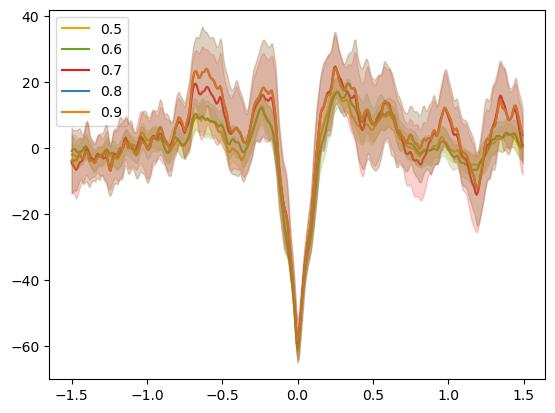

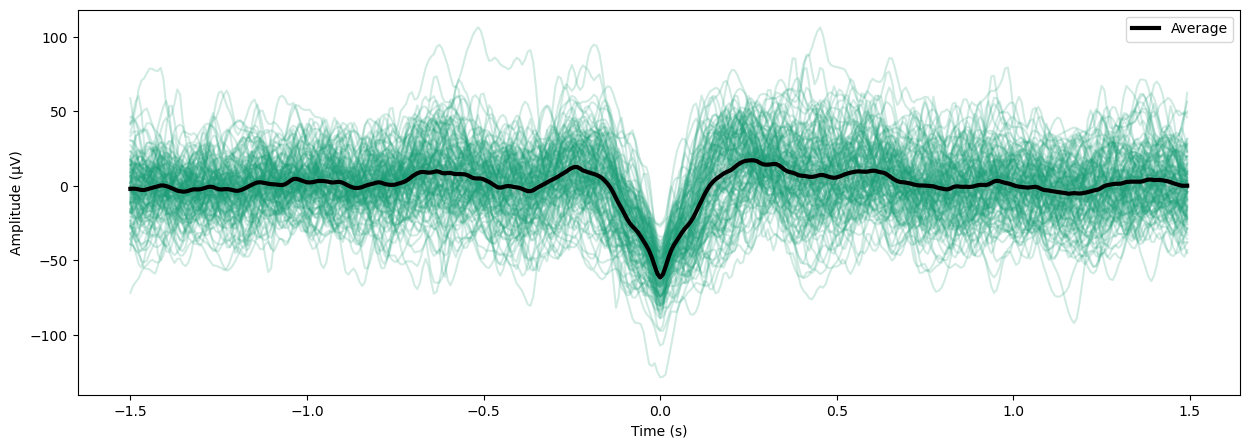

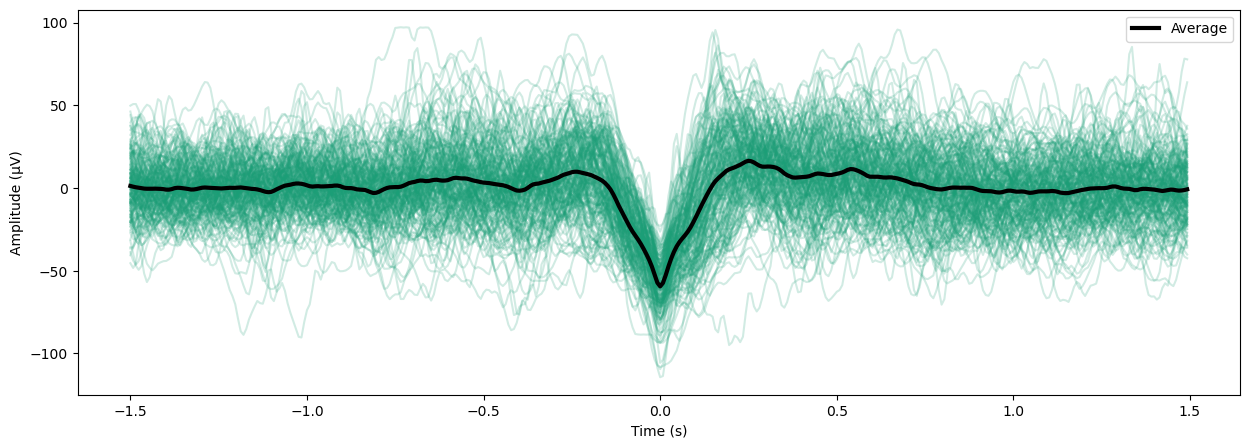

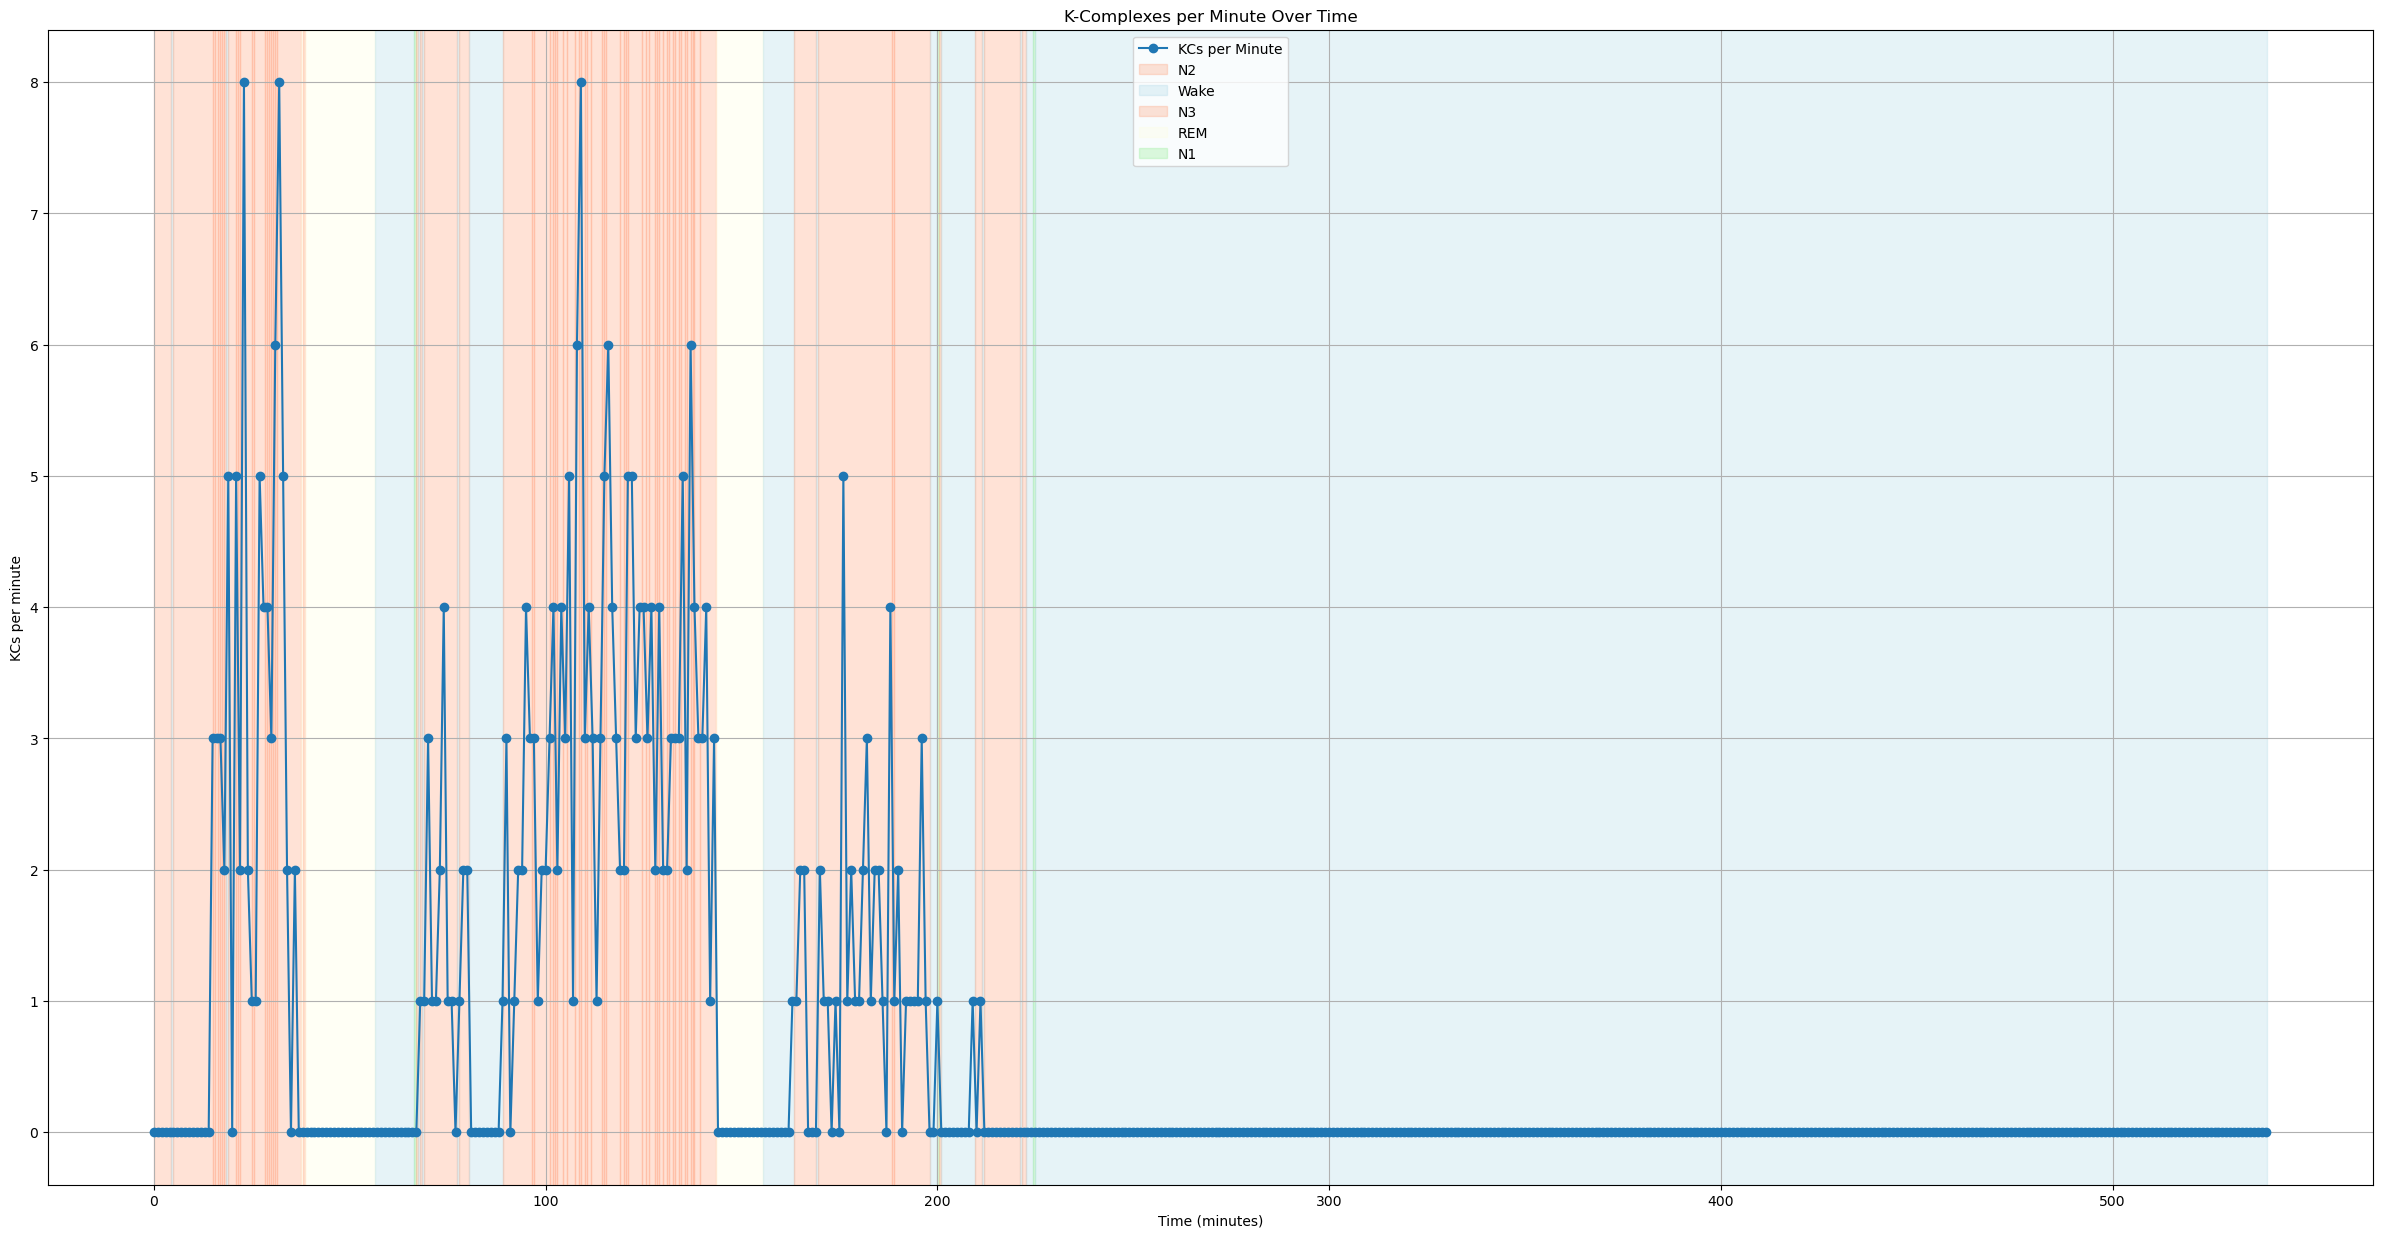

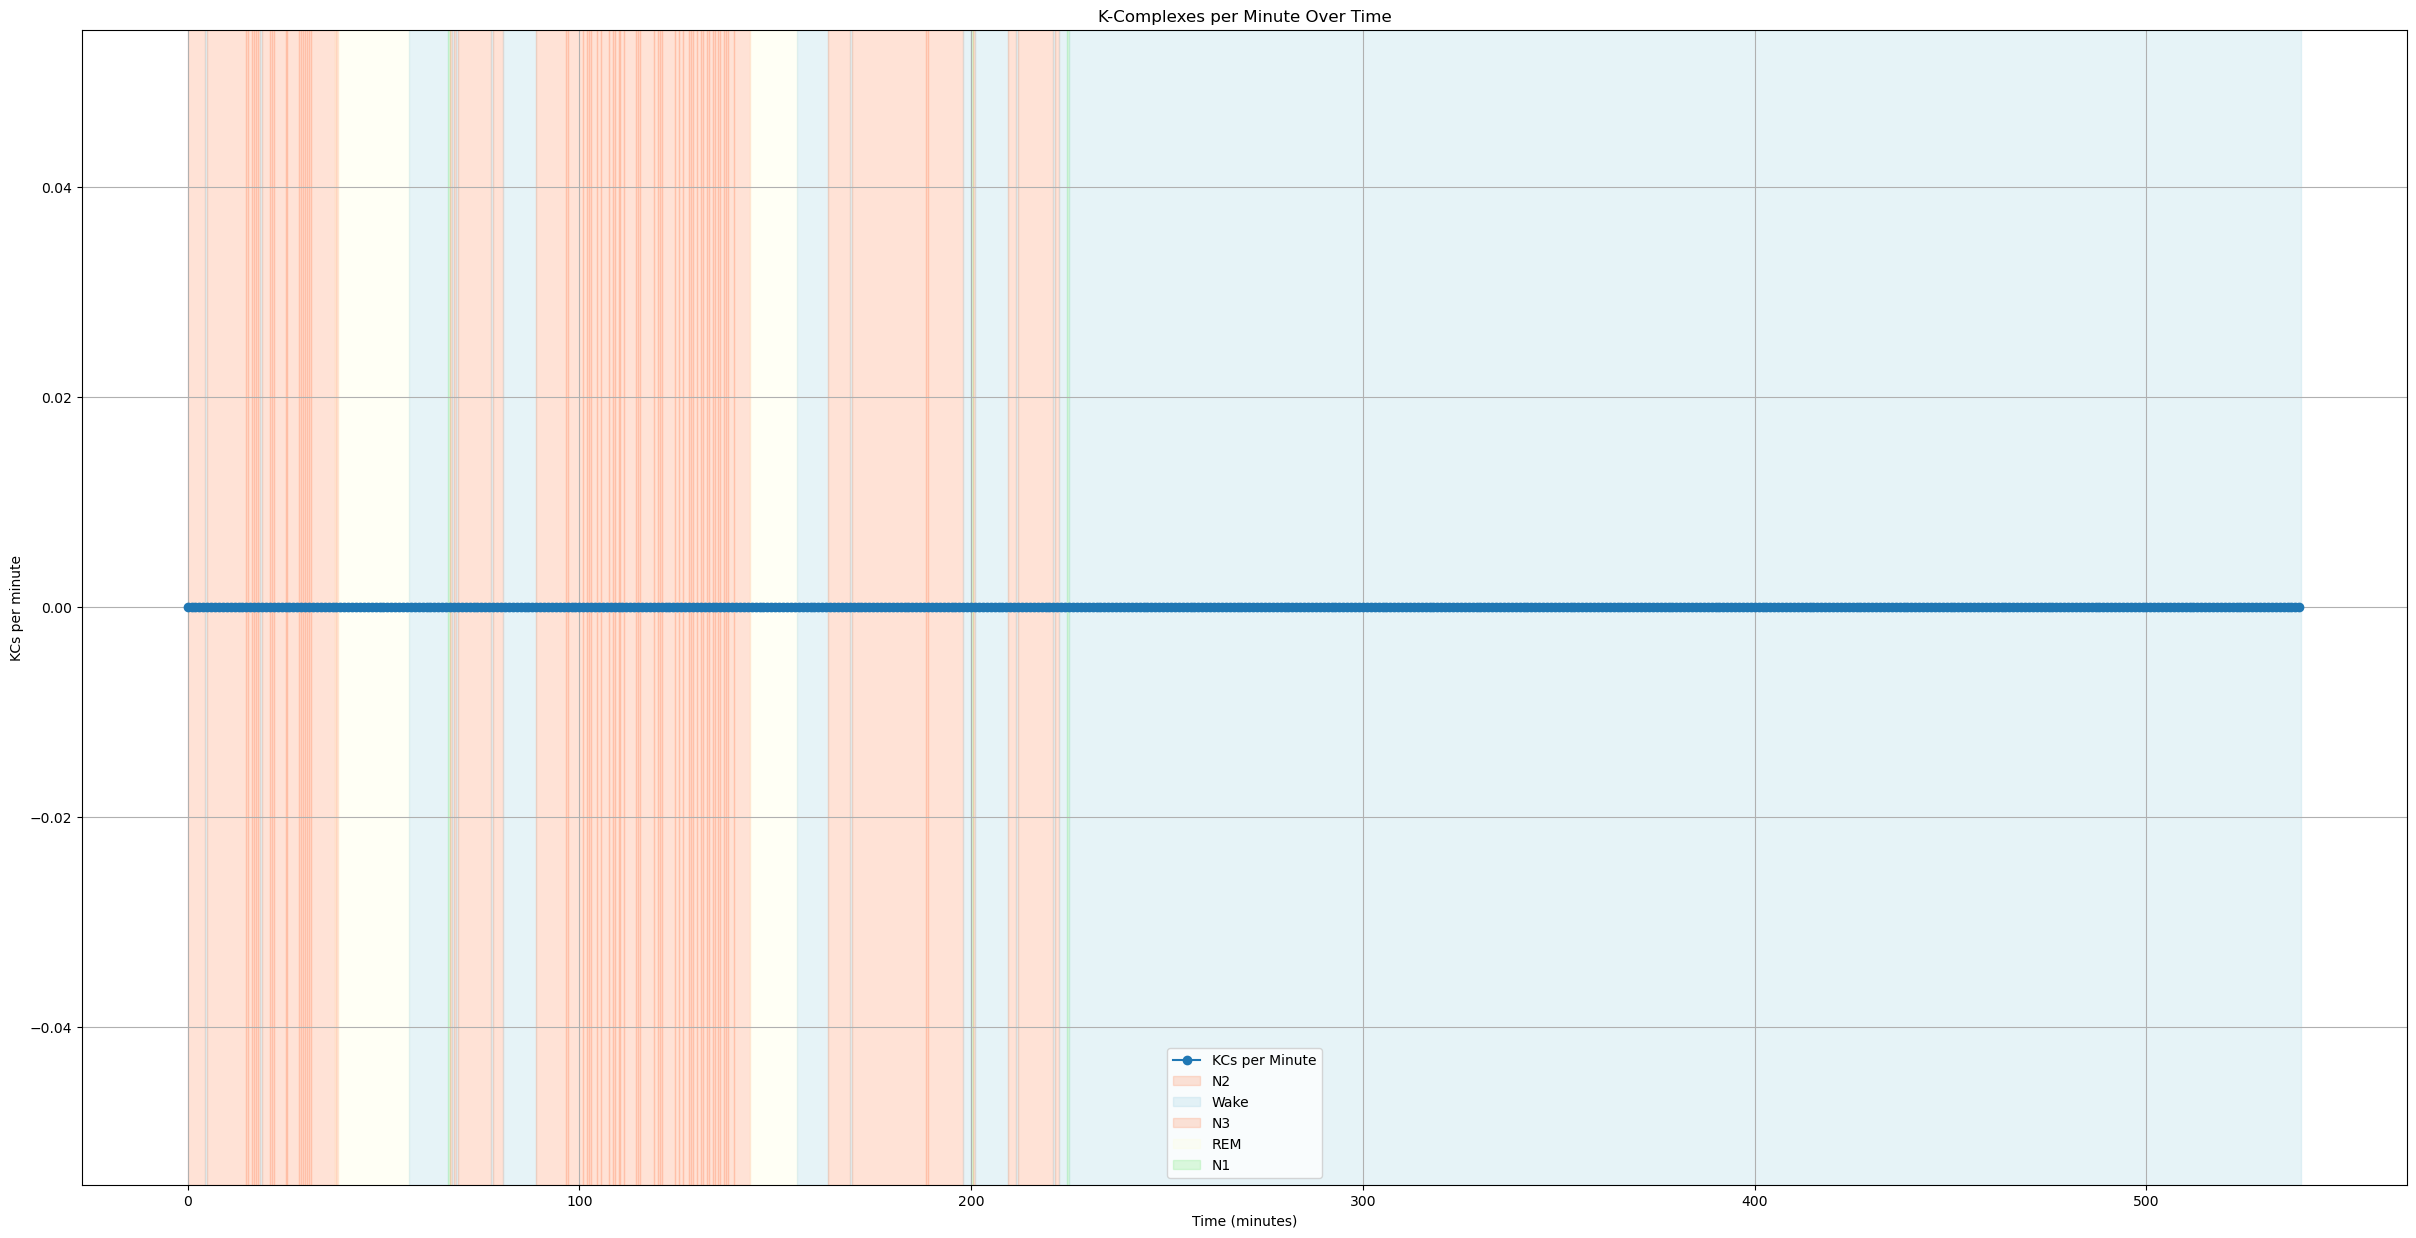

0.5888888888888889


In [6]:
index = 1
load_kc(index, vis=True)

git push -u origin main

### Estimate Precision & Recall
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

### Explore Population

In [7]:
population_columns_of_interest = ["nsrrid", "bmi_s1", "gender", "height", "weight", "waist", "age_category_s1", "avgsat", "minsat", "ethnicity"]

population_selected_df = population_df[population_columns_of_interest]
population_selected_df_subset = population_selected_df

#### Box Plot the Average KC/min by population characteristics

In [113]:
def filter_kcs_by_minutes_and_stages(minutes, kcs_per_minute, stages, valid_stages):
    """
    Filter the kcs_per_minute entries where the minutes are in sleep stages that are not valid.

    Parameters:
    - minutes (ndarray): Array of minute intervals.
    - kcs_per_minute (ndarray): Array of K-complexes per minute.
    - stages (pd.DataFrame): Dataframe with columns 'label', 'dur', and 'onset' for each sleep stage.
    - valid_stages (list): List of valid sleep stages for K-complex detection.

    Returns:
    - filtered_minutes (ndarray): The minutes within valid sleep stages.
    - filtered_kcs_per_minute (ndarray): The kcs_per_minute within valid sleep stages.
    """
    valid_minutes = []
    valid_kcs_per_minute = []

    for minute, kcs in zip(minutes, kcs_per_minute):
        minute_start = minute * 60
        minute_end = minute_start + 60
        is_valid = False
        for _, row in stages.iterrows():
            if row['label'] in valid_stages:
                stage_start = row['onset']
                stage_end = row['onset'] + row['dur']
                if stage_start <= minute_start < stage_end:
                    is_valid = True
                    break
        if is_valid:
            valid_minutes.append(minute)
            valid_kcs_per_minute.append(kcs)

    return np.array(valid_minutes), np.array(valid_kcs_per_minute)


def calculate_kc_density_for_index(index):
    #print(f'Handling index {index}')
    
    edf_filename = file_paths[index][0]
    annot_filename = file_paths[index][1]
    
    kc_dir = os.path.join(kcs_dir, os.path.basename(edf_filename).replace('.edf', ''))

    valid_edf_output_dir = os.path.join(kc_dir, 'valid_kcs', 'edfs')
    invalid_edf_output_dir = os.path.join(kc_dir, 'invalid_kcs', 'edfs')
    
    labels_valid, onsets_valid, probas_valid = load_valid_kc_metadata(kc_dir)
    labels_invalid, onsets_invalid, probas_invalid = load_invalid_kc_metadata(kc_dir)
    
    #print(f'Loaded {labels_valid.shape[0]} valid KCs')
    #print(f'Loaded {labels_invalid.shape[0]} invalid KCs')

    labels_combined = np.concatenate((labels_valid, labels_invalid))
    onsets_combined = np.concatenate((onsets_valid, onsets_invalid))
    probas_combined = np.concatenate((probas_valid, probas_invalid))
    
    # Only select the onsets that correspond to pobas with more than threshold
    # filtered_onsets = onsets_combined[probas_combined > 0.7]
    
    total_duration = get_total_recording_time(annot_filename)  # in seconds
    stages = import_event_and_stages_SHHS(annot_filename)[1]
    
    minutes, kcs_per_minute = calculate_kcs_per_minute(onsets_combined, SAMPLING_FREQ, total_duration)
    
    # Remove the kcs_per_minute entries where minutes is in a sleep stage that is not any of WANTED_SLEEP_STAGES
    valid_minutes, valid_kcs_per_minute = filter_kcs_by_minutes_and_stages(minutes, kcs_per_minute, stages, WANTED_SLEEP_STAGES)
    
    avg_kc_density = np.mean(valid_kcs_per_minute)
    
    return avg_kc_density

In [114]:
from multiprocessing import Pool
from tqdm import tqdm

# Wrapper function to use tqdm with Pool
def pool_map_with_progress(func, iterable, n_jobs, desc="Processing"):
    with Pool(n_jobs) as pool:
        result = list(tqdm(pool.imap(func, iterable), total=len(iterable), desc=desc))
    return result

# Parallel processing function
def parallel_process(df, func, n_jobs=4):
    return pool_map_with_progress(func, df.index, n_jobs, desc="Calculating KC density")

population_selected_df_subset['avg_kc_density'] = parallel_process(population_selected_df_subset, calculate_kc_density_for_index, n_jobs=8)

Calculating KC density: 100%|██████████| 2000/2000 [13:27<00:00,  2.48it/s]


In [115]:
population_selected_df_subset.head()

,nsrrid,bmi_s1,gender,height,weight,waist,age_category_s1,avgsat,minsat,ethnicity,avg_kc_density
0,200001,21.777553,1,178.0,65.0,86.0,7,92.842202,85.0,2,1.430000
1,200002,32.950680,1,168.0,93.0,107.0,9,94.324476,82.0,2,2.058824
2,200003,24.114150,2,145.0,51.0,82.0,9,95.417794,82.0,2,1.810169
3,200004,20.185185,1,180.0,64.0,85.0,6,95.966722,92.0,2,2.543860
4,200005,23.309053,2,155.0,56.0,76.0,8,94.603517,83.0,2,1.118421


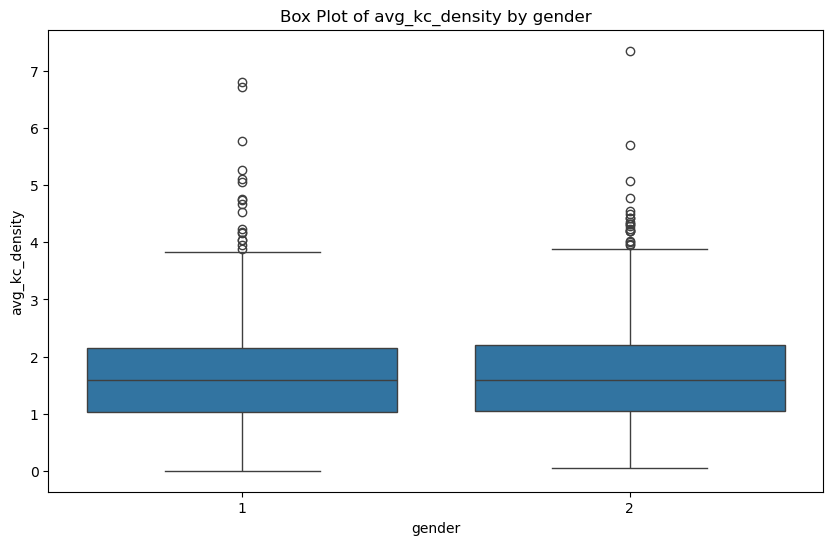

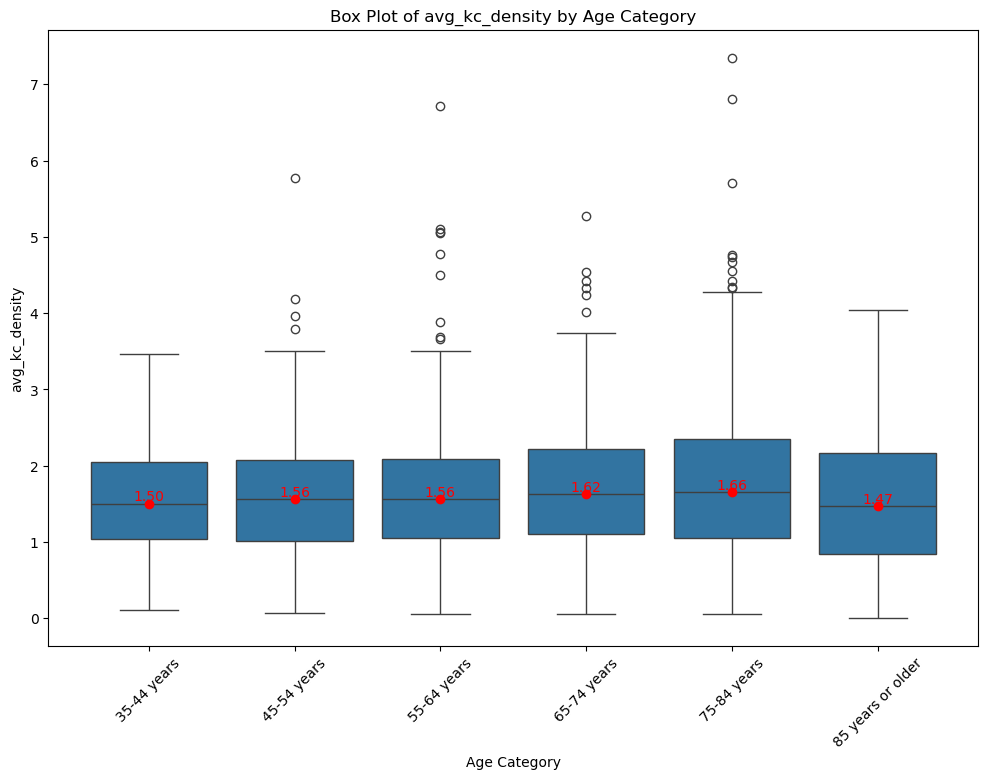

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create a box plot
def create_box_plot(data, x_feature, y_feature='avg_kc_density'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_feature, y=y_feature, data=data)
    plt.title(f'Box Plot of {y_feature} by {x_feature}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()
    
def create_age_box_plot(data, age_feature='age_category_s1', y_feature='avg_kc_density'):
    data_copy = data.copy()
    
    # Map the age categories to their labels
    data_copy['age_category_label'] = data_copy[age_feature].map(AGE_LABELS)

    # Ensure the correct order of age categories
    sorted_age_labels = [AGE_LABELS[key] for key in sorted(AGE_LABELS.keys())]
    
    # Create the box plot
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='age_category_label', y=y_feature, data=data_copy, order=sorted_age_labels)
    
    # Calculate and plot the mean for each category
    means = data_copy.groupby('age_category_label')[y_feature].median()
    for i, label in enumerate(sorted_age_labels):
        plt.scatter(i, means[label], color='red', zorder=5)
        plt.text(i, means[label], f'{means[label]:.2f}', ha='center', va='bottom', color='red')
    
    plt.title(f'Box Plot of {y_feature} by Age Category')
    plt.xlabel('Age Category')
    plt.ylabel(y_feature)
    plt.xticks(rotation=45)  # Rotate labels for better readability
    plt.show()

# Example: Box plot of avg_kc_density by gender
create_box_plot(population_selected_df_subset, x_feature='gender')

# Example: Box plot of avg_kc_density by age category
create_age_box_plot(population_selected_df_subset)

### Characterise the KC
- [x] Average Density
- [] Duration
- [] FFT Features
- [] Minimum Amplitude
- [] Maximum Amplitude


In [ ]:
from scipy.ndimage import gaussian_filter1d

def get_kc_characteristics(index, vis=True):
    edf_filename = file_paths[index][0]
    annot_filename = file_paths[index][1]
    
    kc_dir = os.path.join(kcs_dir, os.path.basename(edf_filename).replace('.edf', ''))
    # Load the saved EDF files
    valid_edf_output_dir = os.path.join(kc_dir, 'valid_kcs', 'edfs')
    invalid_edf_output_dir = os.path.join(kc_dir, 'invalid_kcs', 'edfs')

    valid_epochs_data_loaded = load_kcs_edf_files(valid_edf_output_dir)
    invalid_epochs_data_loaded = load_kcs_edf_files(invalid_edf_output_dir)
    
    print(valid_epochs_data_loaded.shape)

    # Load the stored inference files for valid KCs
    labels_valid, onsets_valid, probas_valid = load_valid_kc_metadata(kc_dir)

    # Load the stored inference files for invalid KCs
    labels_invalid, onsets_invalid, probas_invalid = load_invalid_kc_metadata(kc_dir)

    print(f'Loaded {labels_valid.shape[0]} valid KCs')
    print(f'Loaded {labels_invalid.shape[0]} invalid KCs')

    # Combine valid and invalid KCs
    labels_combined = np.concatenate((labels_valid, labels_invalid))
    onsets_combined = np.concatenate((onsets_valid, onsets_invalid))
    probas_combined = np.concatenate((probas_valid, probas_invalid))
    
    epochs_data_combined = np.concatenate((valid_epochs_data_loaded, invalid_epochs_data_loaded)) * 10**6
    
    # Compute the average KC
    avg_kc = np.mean(epochs_data_combined, axis=0)
    std_kc = np.std(epochs_data_combined, axis=0)
    
    # Step 1: Find the minimum in the average KC
    min_index = np.argmin(avg_kc)
    min_value = avg_kc[min_index]
    
    # Step 2: Smooth the average KC heavily & find the derivation
    smoothed_avg_kc = gaussian_filter1d(avg_kc, sigma=20)
    derivative = np.gradient(smoothed_avg_kc)

    
    # Step 3: Calculate variance over sliding windows to determine the duration
    window_size = 50  # Define window size
    var_kc = np.array([np.var(smoothed_avg_kc[i:i+window_size]) for i in range(len(smoothed_avg_kc) - window_size + 1)])
    var_kc = np.pad(var_kc, (window_size//2, window_size//2 - 1), 'edge')  # Pad to match original length
    
    # Use a threshold to determine the end of the K-Complex
    threshold = 2  # Define threshold as half the mean variance
    left_duration_index = np.where(var_kc[:min_index] < threshold)[0][-1] if len(np.where(var_kc[:min_index] < threshold)[0]) > 0 else 0
    right_duration_index = np.where(var_kc[min_index:] < threshold)[0][0] + min_index if len(np.where(var_kc[min_index:] < threshold)[0]) > 0 else len(smoothed_avg_kc) - 1
    duration = (right_duration_index - left_duration_index) / SAMPLING_FREQ
        
    # Step 4: Find the right side peak in the average KC
    right_peak_index = min_index + np.argmax(avg_kc[min_index:])
    right_peak_value = avg_kc[right_peak_index]
    
    # Plot both the avg_kc with std_kc, the smoothed_avg_kc, and the derivative
    if vis:
        plt.figure(figsize=(12, 8))

        # Plot avg_kc with std_kc
        plt.plot(avg_kc, label='Average KC')
        plt.fill_between(range(len(avg_kc)), avg_kc - std_kc, avg_kc + std_kc, color='b', alpha=0.2, label='Standard Deviation')

        # Plot smoothed_avg_kc
        plt.plot(smoothed_avg_kc, label='Smoothed Average KC', linestyle='--')
        
        # Mark the duration
        if not np.isnan(duration):
            plt.axvline(x=left_duration_index, color='r', linestyle='--', label='Left Duration Index')
            plt.axvline(x=right_duration_index, color='g', linestyle='--', label='Right Duration Index')
            plt.hlines(y=np.min(avg_kc) - 20, xmin=left_duration_index, xmax=right_duration_index, colors='k', linestyles='-', label='Duration')

        # Mark the minimum
        plt.axvline(x=min_index, color='orange', linestyle='-', label='Minimum Index')

        plt.title('KC Characteristics')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(12, 8))
        
        # Plot smoothed_avg_kc
        plt.plot(smoothed_avg_kc, label='Smoothed Average KC', linestyle='--')

        # Plot derivative
        plt.plot(derivative, label='Derivative of Smoothed KC', linestyle=':')

        # Mark the duration
        if not np.isnan(duration):
            plt.axvline(x=left_duration_index, color='r', linestyle='--', label='Left Duration Index')
            plt.axvline(x=right_duration_index, color='g', linestyle='--', label='Right Duration Index')
            plt.hlines(y=np.min(avg_kc) - 20, xmin=left_duration_index, xmax=right_duration_index, colors='k', linestyles='-', label='Duration')

        # Mark the minimum
        plt.axvline(x=min_index, color='orange', linestyle='-', label='Minimum Index')

        plt.title('Smoothed Average KC')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
        
        
        plt.figure(figsize=(12, 8))
        
        # Plot derivative
        plt.plot(derivative, label='Derivative of Smoothed KC', linestyle=':')

        # Mark the duration
        if not np.isnan(duration):
            plt.axvline(x=left_duration_index, color='r', linestyle='--', label='Left Duration Index')
            plt.axvline(x=right_duration_index, color='g', linestyle='--', label='Right Duration Index')

        # Mark the minimum
        plt.axvline(x=min_index, color='orange', linestyle='-', label='Minimum Index')

        plt.title('KC Derivative of Smoothed KC Characteristics')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
    
    kc_characteristics = {
        'min_value': min_value,
        'min_index': min_index,
        'duration': duration,
        'right_peak_value': right_peak_value,
        'right_peak_index': right_peak_index
    }
    
    return kc_characteristics
    
get_kc_characteristics(11)

In [ ]:
# Create a new dataset with 3 columns: column_id, display_name, description
mapped_data = {
    'column_id': [],
    'display_name': [],
    'description': []
}

for column_id in population_df.columns.to_list():
    mapped_data['column_id'].append(column_id)
    mapped_data['display_name'].append(id_to_display_name.get(column_id))
    mapped_data['description'].append(id_to_description.get(column_id))

mapped_df = pd.DataFrame(mapped_data)
mapped_df.to_csv(os.path.join(datasets_dir, 'shhs1-dataset-dictionary-0.20.0.csv'))